## Compare essentiality of WGD vs. SSD paralogs

**Input:** Gene summary file

Notes:
* Whole genome duplicates are annotated based on whether they appear in the set from Makino and McLysaght and/or the strict set of Ohnologs from Singh et al  
* All paralog pairs that don't appear in either of those sets are called SSDs

In [1]:
import pandas as pd
import os
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../data/'+'/'.join(folders) +'/'+fname)

file_gene_summary = get_local_data_path(['processed', 'results'], 'gene_summary_0.47.csv')

In [3]:
gene_data = pd.read_csv(file_gene_summary)
print('Num paralogs: ', gene_data[gene_data.num_paralogs > 0].shape[0])
print('Paralogs that are WGDs: %.2f%%' % (sum(gene_data.WGD=='WGD')/sum(gene_data.num_paralogs > 0)*100))
print('Paralogs that are SSDs: %.2f%%' % (sum(gene_data.WGD=='SSD')/sum(gene_data.num_paralogs > 0)*100))
gene_data[:1]

Num paralogs:  10130
Paralogs that are WGDs: 64.44%
Paralogs that are SSDs: 35.56%


,entrez_id,essential_percent,category,ensembl_id,symbol,percent_matched_in_paralog,num_paralogs,WGD
0,8036,0.069892,Sometimes,ENSG00000108061,SHOC2,0.254296,2,SSD


### Test WGD and SSD subsets of paralogs independently
#### 1. WGD subset

In [4]:
wgd_data = gene_data[(gene_data.num_paralogs == 0) | (gene_data.WGD == 'WGD')]
df = wgd_data.assign(is_paralog = wgd_data.num_paralogs > 0)
df = df.assign(is_never = (df.category == 'Never'), is_broadly = (df.category == 'Broadly'))
ctab = pd.crosstab(df.is_paralog, df.is_never)
assert(ctab.sum().sum() == df.shape[0])
print('WGD subset:')
print('Are paralogs enriched in never essentials? FET:', stats.fisher_exact(ctab))
ctab = pd.crosstab(~df.is_paralog, df.is_broadly).iloc[[1,0],:]
assert(ctab.sum().sum() == df.shape[0])
print('Are singletons enriched in broadly essentials? FET:', stats.fisher_exact(ctab))

WGD subset:
Are paralogs enriched in never essentials? FET: (1.6287982895864086, 4.887248314711825e-43)
Are singletons enriched in broadly essentials? FET: (0.0998814614465493, 1.7352186230114818e-151)


#### 2. SSD subset

In [5]:
ssd_data = gene_data[(gene_data.num_paralogs == 0) | (gene_data.WGD == 'SSD')]
df = ssd_data.assign(is_paralog = ssd_data.num_paralogs > 0)
df = df.assign(is_never = (df.category == 'Never'), is_broadly = (df.category == 'Broadly'))
ctab = pd.crosstab(df.is_paralog, df.is_never)
assert(ctab.sum().sum() == df.shape[0])
print('SSD subset:')
print('Are paralogs enriched in never essentials? FET:', stats.fisher_exact(ctab))
ctab = pd.crosstab(~df.is_paralog, df.is_broadly).iloc[[1,0],:]
assert(ctab.sum().sum() == df.shape[0])
print('Are singletons enriched in broadly essentials? FET:', stats.fisher_exact(ctab))

SSD subset:
Are paralogs enriched in never essentials? FET: (1.8790889371144661, 5.146200305254311e-51)
Are singletons enriched in broadly essentials? FET: (0.2824949439943087, 1.483620433731856e-50)


### Compare essentiality for WGDs and SSDs 

In [6]:
def do_fet_for_wgd_vs_ssd(category):
    df = gene_data[gene_data.num_paralogs > 0] # Drop singletons
    df = df.assign(is_category = (df.category == category))
    ctab = pd.crosstab(df.is_category, df.WGD, dropna=False)
    assert(ctab.sum().sum() == df.shape[0])
    fet = stats.fisher_exact(ctab)
    print('Are WGDs enriched/depleted in', category, 'essential genes?')
    print('FET: OR =', np.round(fet[0],2), 'pval =', fet[1])
    #display(ctab)

print('WGD vs. SSD:')
do_fet_for_wgd_vs_ssd("Broadly")
do_fet_for_wgd_vs_ssd("Sometimes")
do_fet_for_wgd_vs_ssd("Never")

WGD vs. SSD:
Are WGDs enriched/depleted in Broadly essential genes?
FET: OR = 0.35 pval = 1.779964462737648e-14
Are WGDs enriched/depleted in Sometimes essential genes?
FET: OR = 1.27 pval = 6.649926887940356e-09
Are WGDs enriched/depleted in Never essential genes?
FET: OR = 0.87 pval = 0.0006042787218205547


In [12]:
# Generate contingency table
tab = pd.crosstab(gene_data.category, gene_data.WGD)
assert(tab.sum().sum() == gene_data.shape[0])
tab = tab.loc[['Never', 'Sometimes', 'Broadly'], ['WGD', 'SSD', 'Singleton']] # order how I want them
tab = tab.apply(lambda x: x/sum(x.values)).T
display(tab)

category,Never,Sometimes,Broadly
WGD,,,
WGD,0.514400,0.471814,0.013787
SSD,0.549972,0.411993,0.038034
Singleton,0.394072,0.483151,0.122777


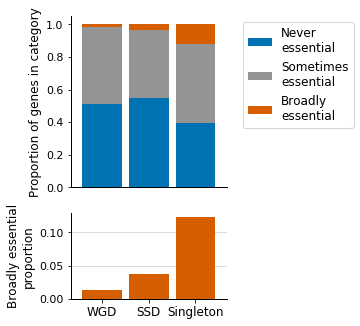

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(2.8, 5.2), gridspec_kw={'height_ratios': [2, 1]})

# 1/ top - proportions of essentiality categories
tab.plot.bar(stacked=True, rot=0, ax=ax1, color=get_color_palette(1), width=0.85)
ax1.set_ylabel('Proportion of genes in category')
ax1.set_xlabel(''); ax1.set_xticks([])
# ax1.legend(loc='upper right', bbox_to_anchor=(1.02,-0.8), fontsize=11,
#            labels=['Never essential', 'Sometimes essential', 'Broadly essential'])
ax1.legend(loc='upper right', bbox_to_anchor=(1.85,1),
           labels=['Never\nessential', 'Sometimes\nessential', 'Broadly\nessential'])

# 2/ bottom - proportion of broadly essential genes
tab.loc[:, 'Broadly':].plot.bar(ax=ax2, rot=0, color=get_color_palette(3), width=0.85)
ax2.set_ylabel('Broadly essential\nproportion'); ax2.set_xlabel('')
ax2.legend().remove()
ax2.xaxis.set_tick_params(labelsize=mpl.rcParams['axes.labelsize'])
ax2.grid(axis='y')
# plt.savefig('../figures/fig_4AB.svg', bbox_inches='tight', dpi=300)